In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config

In [2]:
config = read_config(
    os.path.join(GTE_DIR,'configs/2022_tracking/01_01.yaml'))
analyze_year=True
year=2022
global global_rmse
global_rmse = config["Global_sqrt_mse"]
classifiacation_palette = ['#e41a1c', '#377eb8', "#4daf4a"]
temperature_palette = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']

In [3]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    else:
        return 'SON'
if os.uname()[1]=="n2o":
    combined_cloud_df = pd.read_parquet(f"/wolke_scratch/dnikolo/Final_results/{year}_all.parquet")
    glaciations_df = pd.read_parquet(f"/wolke_scratch/dnikolo/Final_results/{year}_glac.parquet")
if os.uname()[1][:3]=="eu-":
    combined_cloud_df = pd.read_parquet(f"/cluster/work/climate/dnikolo/Cloud_analysis/full_years/{year}_all.parquet")
    glaciations_df = pd.read_parquet(f"/cluster/work/climate/dnikolo/Cloud_analysis/full_years/{year}_glac.parquet")
combined_cloud_df['Season'] = combined_cloud_df['track_start_time'].dt.month.apply(month_to_season)
glaciations_df["Radius [km]"]=np.sqrt(glaciations_df["avg_size[km]"]/np.pi)
glaciations_df['Season'] = glaciations_df['track_start_time'].dt.month.apply(month_to_season)
for i,row in glaciations_df.iterrows():
    glaciations_df.loc[i, "Glaciation IF Maximum"] = row["ice_frac_hist"][int(row["Glac_peak_ind"])]

combined_cloud_df = combined_cloud_df[~combined_cloud_df.is_large_pix_cloud]
glaciations_df = glaciations_df[~glaciations_df.is_large_pix_cloud]

glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")



In [4]:
glaciations_df["Glaciation rate"] = glaciations_df["Magnitude"] / glaciations_df["Glaciation time [h]"]

# Assigning size bins with custom labels
glaciations_df["Size bin"] = pd.cut(
    glaciations_df["avg_size[km]"],
    bins=[1000, 2000, 5000, 10000, np.inf],
    labels=["Small", "Medium", "Large", "Very Large"]
)

# Assigning lifetime bins with custom labels
glaciations_df["Lifetime bin"] = pd.cut(
    glaciations_df["Lifetime [h]"],
    bins=[0, 1, 2, 5, np.inf],
    labels=["Very Short", "Short", "Medium", "Long"])

glaciations_df["Magnitude bin"] =pd.cut(
    glaciations_df["Magnitude"],
    bins=[0.4, 0.6, 0.8, 1],
    labels=["Small", "Medium", "Full"])
glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")
# Velry large long lived clouds
vlll_glaciations = glaciations_df[(glaciations_df["Lifetime bin"]=="Long") & (glaciations_df["Size bin"]=="Very Large")]
vlll_clouds = glaciating_clouds[(glaciating_clouds["Lifetime bin"]=="Long") & (glaciating_clouds["Size bin"]=="Very Large")]
linear_glac=glaciations_df[(glaciations_df["Linear"]==True) ]

Distribution of post-glaciation IF

-36 -36 to -30
-30 -30 to -24
-24 -24 to -18
-18 -18 to -12
-12 -12 to -6


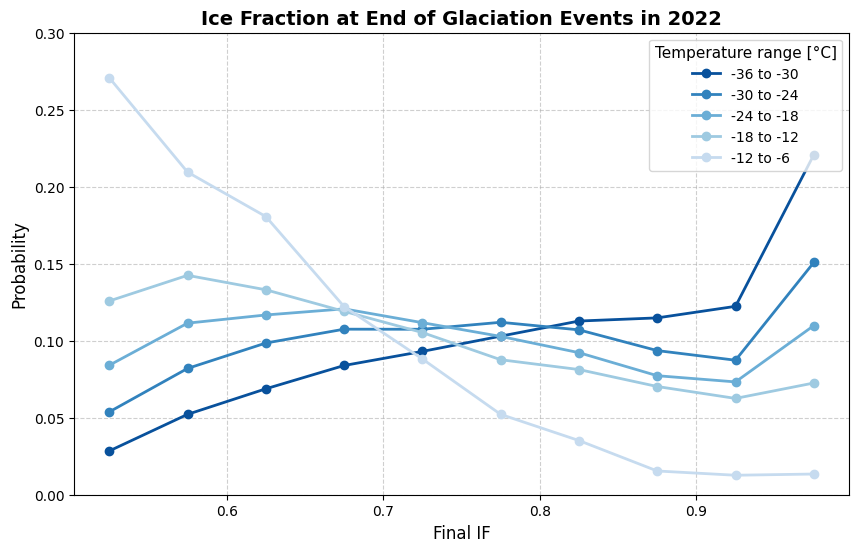

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assuming vlll_glaciations is your dataframe
binwidth = 0.05

# Generate labels
labels = [f'{config["min_temp_arr"][i]} to {config["max_temp_arr"][i]}' 
          for i in range(len(config["min_temp_arr"]))]

# Compute histogram data
bins = np.arange(0.5, 1+binwidth, binwidth)

# Group by min_temp and calculate probability density
grouped = glaciations_df.groupby("min_temp")["Glaciation IF Maximum"]
hist_data = {temp: np.histogram(data, bins=bins, density=True)[0] for temp, data in grouped}

# Convert to DataFrame for easier plotting
hist_df = pd.DataFrame(hist_data, index=bins[:-1])

# Set color palette
num_lines = len(hist_df.columns)
# colors = cm.viridis(np.linspace(0, 1, num_lines))  # Smooth gradient from viridis colormap
colors = temperature_palette[1:]
# Plot lineplot
plt.figure(figsize=(10, 6))
# sns.lineplot(data=hist_df,)
for i, (temp, color) in enumerate(zip(hist_df.columns, colors[::-1])):
    print(temp,labels[-i-1])
    plt.plot(hist_df.index + binwidth/2, hist_df[temp] / hist_df[temp].sum(), 
             label=labels[-i-1], color=color, linewidth=2, marker='o')
    # sns.scatterplot(x=hist_df.index + binwidth/2,y= hist_df[temp] / hist_df[temp].sum(), 
    #          label=labels[i], color=color)

# Labels and Title
plt.xlabel("Final IF", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Ice Fraction at End of Glaciation Events in 2022", fontsize=14, fontweight='bold')
plt.ylim(0,0.3)
# Legend
plt.legend(title="Temperature range [°C]", frameon=True, loc="upper right", fontsize=10, title_fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)  # Dashed grid lines for better visibility
filename = os.path.join(GTE_DIR,"Result_graphs/End_of_glaciation_IF_by_temp")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)
# Show plot
plt.show()

/cluster/work/climate/dnikolo/dump/ipykernel_2220846/3309691080.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=glaciations_df["Glaciation IF Maximum"],binwidth=0.05,binrange=[0.5,1],palette=classifiacation_palette,stat="probability")


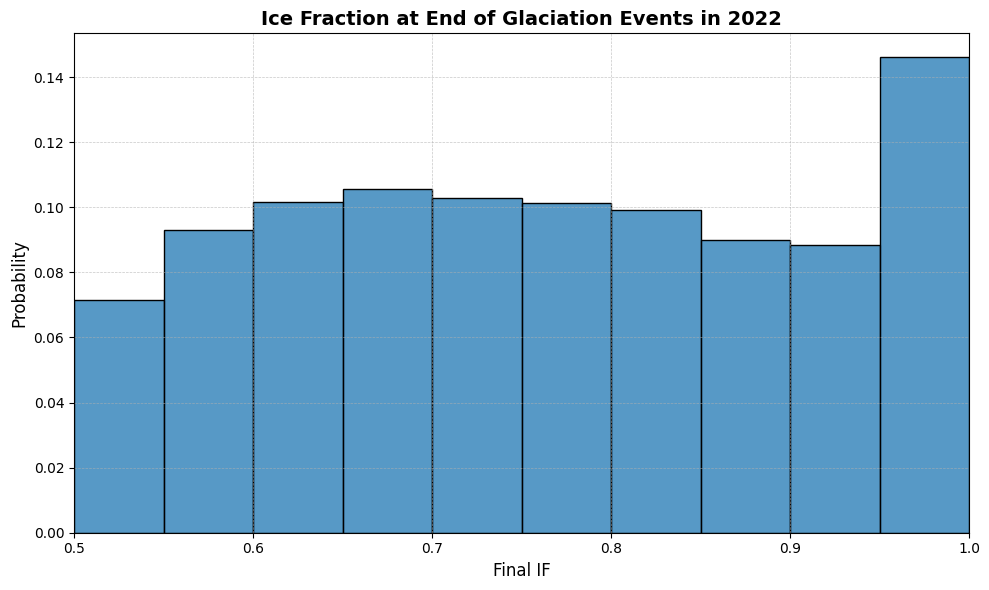

In [6]:
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=glaciations_df["Glaciation IF Maximum"],binwidth=0.05,binrange=[0.5,1],palette=classifiacation_palette,stat="probability")
plt.xlim(0.5,1)
ax.set_title("Ice Fraction at End of Glaciation Events in 2022", fontsize=14, weight="bold")
ax.set_xlabel("Final IF", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
filename = os.path.join(GTE_DIR,"Result_graphs/End_of_glaciation_IF")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)


Distribution of glaciation magnitudes

/cluster/work/climate/dnikolo/dump/ipykernel_2220846/3292672195.py:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(glaciations_df,x="Magnitude",binwidth=0.05,stat="probability",hue="Hemisphere", palette=classifiacation_palette,common_norm=False)


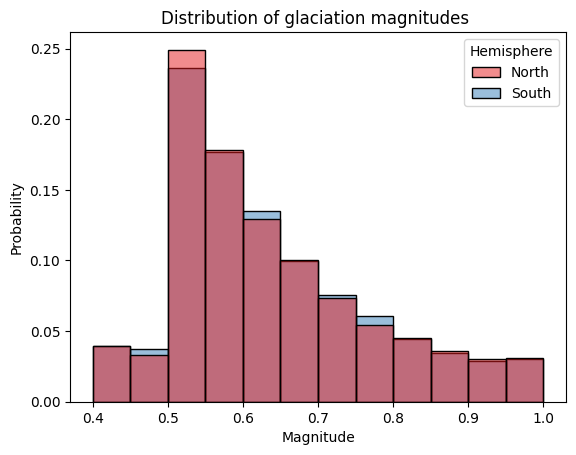

In [7]:
sns.histplot(glaciations_df,x="Magnitude",binwidth=0.05,stat="probability",hue="Hemisphere", palette=classifiacation_palette,common_norm=False)
plt.title("Distribution of glaciation magnitudes ")
filename = os.path.join(GTE_DIR,"Result_graphs/Magnitude_of_glaciation")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


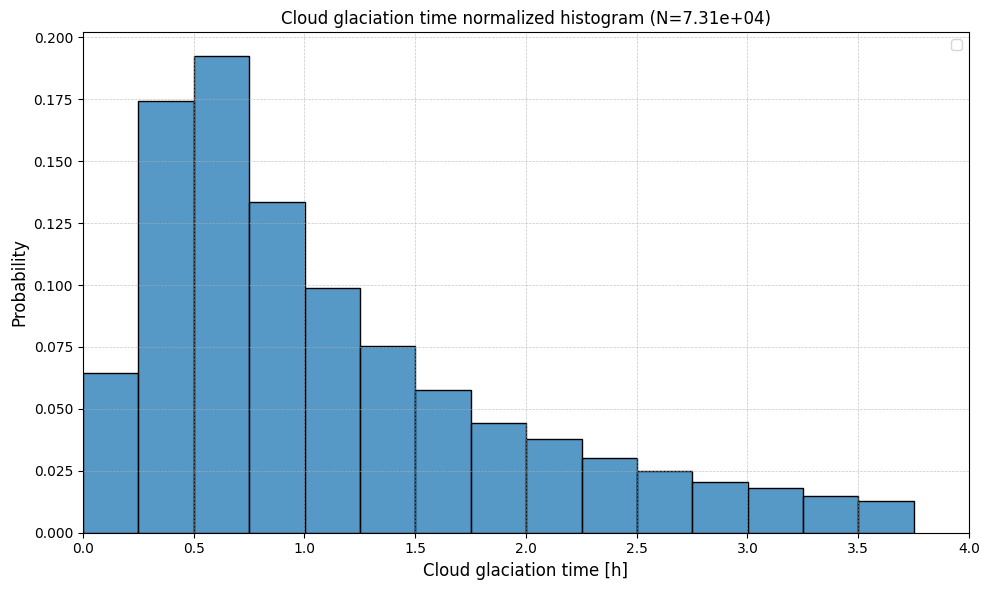

In [8]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",bins=bins,stat="probability",)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df):.2e})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/CGT_stistics.png"),dpi=400)

Glaciation rate distribution histplot

/cluster/work/climate/dnikolo/dump/ipykernel_2220846/1136847088.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.histplot(data = vlll_glaciations , x= "Glaciation rate",hue="min_temp", multiple="dodge",common_norm=False, stat="probability", binwidth=0.5,kde=True,shrink=0.8,line_kws={"linewidth":1},palette=temperature_palette[::-1])


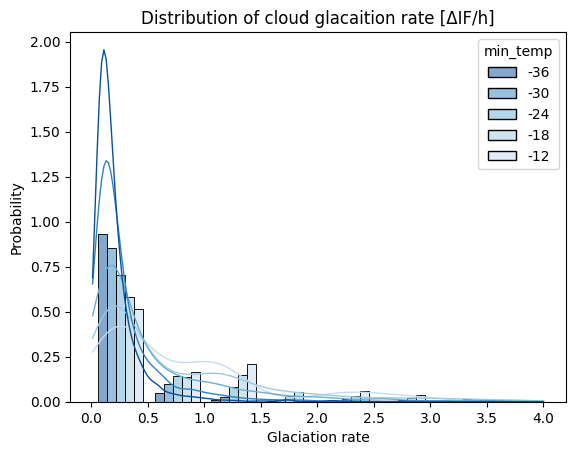

In [9]:
sns.histplot(data = vlll_glaciations , x= "Glaciation rate",hue="min_temp", multiple="dodge",common_norm=False, stat="probability", binwidth=0.5,kde=True,shrink=0.8,line_kws={"linewidth":1},palette=temperature_palette[::-1])
# sns.histplot(data = glaciations_df, x= "Glaciation rate",hue="min_temp", multiple="dodge",common_norm=False, binwidth=0.5,kde=True)
plt.title("Distribution of cloud glacaition rate [ΔIF/h]")
plt.savefig(os.path.join(GTE_DIR,'Result_graphs/Glaciation_Rate_dist_hist.png'),dpi=400)

Glaciation rate distribution lineplot

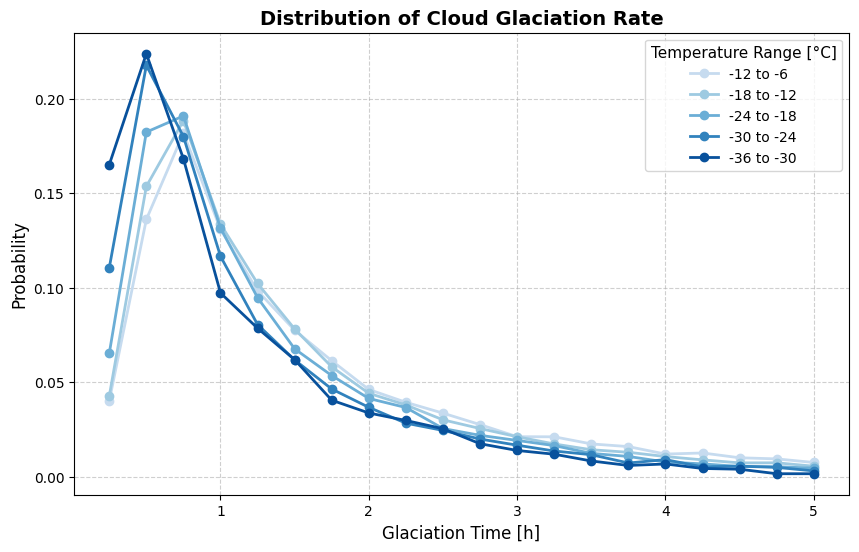

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assuming vlll_glaciations is your dataframe
binwidth = 0.25

# Generate labels
labels = [f'{config["min_temp_arr"][i]} to {config["max_temp_arr"][i]}' 
          for i in range(len(config["min_temp_arr"]))]

# Compute histogram data
glaciation_rates = glaciations_df["Glaciation time [h]"]
bins = np.arange(0.125, 5 + binwidth, binwidth)

# Group by min_temp and calculate probability density
grouped = glaciations_df.groupby("min_temp")["Glaciation time [h]"]
hist_data = {temp: np.histogram(data, bins=bins, density=True)[0] for temp, data in grouped}

# Convert to DataFrame for easier plotting
hist_df = pd.DataFrame(hist_data, index=bins[:-1])

# Set color palette
num_lines = len(hist_df.columns)
# colors = cm.viridis(np.linspace(0, 1, num_lines))  # Smooth gradient from viridis colormap
colors = temperature_palette[1:]
# Plot lineplot
plt.figure(figsize=(10, 6))

for i, (temp, color) in enumerate(zip(hist_df.columns, colors)):
    plt.plot(hist_df.index + binwidth/2, hist_df[temp] / hist_df[temp].sum(), 
             label=labels[i+1], color=color, linewidth=2, marker='o')
    # sns.scatterplot(x=hist_df.index + binwidth/2,y= hist_df[temp] / hist_df[temp].sum(), 
    #          label=labels[i], color=color)

# Labels and Title
plt.xlabel("Glaciation Time [h]", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Distribution of Cloud Glaciation Rate", fontsize=14, fontweight='bold')

# Legend
plt.legend(title="Temperature Range [°C]", frameon=True, loc="upper right", fontsize=10, title_fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)  # Dashed grid lines for better visibility
# plt.savefig(os.path.join(GTE_DIR,'Result_graphs/Glaciation_Rate_dist_line.png'),dpi=400)
# Show plot
plt.show()

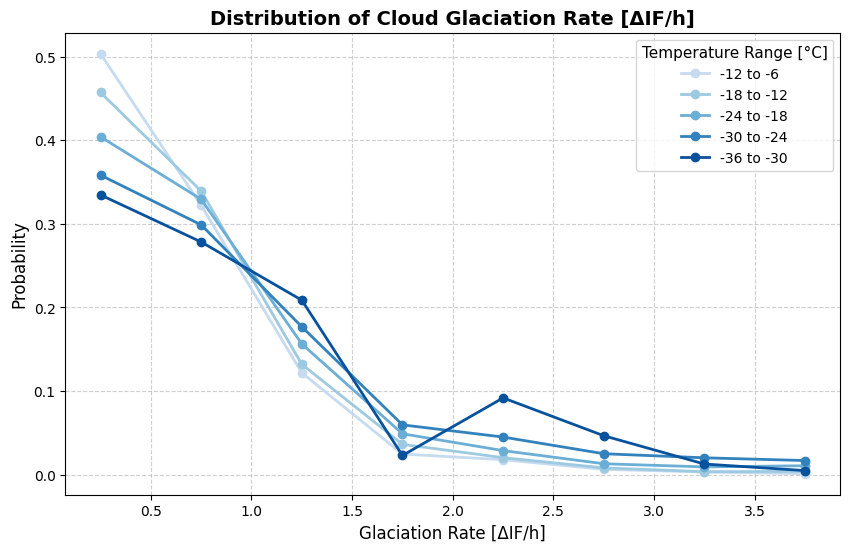

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assuming vlll_glaciations is your dataframe
binwidth = 0.5

# Generate labels
labels = [f'{config["min_temp_arr"][i]} to {config["max_temp_arr"][i]}' 
          for i in range(len(config["min_temp_arr"]))]

# Compute histogram data
glaciation_rates = linear_glac["Glaciation rate"]
bins = np.arange(0, glaciation_rates.max() + binwidth, binwidth)

# Group by min_temp and calculate probability density
grouped = glaciations_df.groupby("min_temp")["Glaciation rate"]
hist_data = {temp: np.histogram(data, bins=bins, density=True)[0] for temp, data in grouped}

# Convert to DataFrame for easier plotting
hist_df = pd.DataFrame(hist_data, index=bins[:-1])

# Set color palette
num_lines = len(hist_df.columns)
# colors = cm.viridis(np.linspace(0, 1, num_lines))  # Smooth gradient from viridis colormap
colors = temperature_palette[1:]
# Plot lineplot
plt.figure(figsize=(10, 6))

for i, (temp, color) in enumerate(zip(hist_df.columns, colors)):
    plt.plot(hist_df.index + binwidth/2, hist_df[temp] / hist_df[temp].sum(), 
             label=labels[i+1], color=color, linewidth=2, marker='o')
    # sns.scatterplot(x=hist_df.index + binwidth/2,y= hist_df[temp] / hist_df[temp].sum(), 
    #          label=labels[i], color=color)

# Labels and Title
plt.xlabel("Glaciation Rate [ΔIF/h]", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Distribution of Cloud Glaciation Rate [ΔIF/h]", fontsize=14, fontweight='bold')

# Legend
plt.legend(title="Temperature Range [°C]", frameon=True, loc="upper right", fontsize=10, title_fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)  # Dashed grid lines for better visibility
plt.savefig(os.path.join(GTE_DIR,'Result_graphs/Glaciation_Rate_dist_line.png'),dpi=400)
# Show plot
plt.show()
